# 🎮 스팀 상호작용 분석: 암시적 피드백 (Implicit Feedback)

## 🎯 분석 목표
- **플레이타임(Playtime)** 데이터를 BPR/LightGCN 모델 학습용으로 전처리.
- **필터링 효과 검증:** 2시간 미만 플레이 제거 시 행렬 밀도가 어떻게 변하는가?


In [1]:
# ====== 1. 환경 설정 및 라이브러리 임포트 ======
import os
import ast
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# 출력 옵션
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
load_dotenv()

# 데이터 경로
DATA_PATH = '../../steam_data/now_steam/australian_users_items.json'
print(f"데이터 경로: {DATA_PATH}")

데이터 경로: ../../steam_data/now_steam/australian_users_items.json


In [2]:
# ====== 2. 데이터 로드 (Data Loading) ======
def load_interaction_data(json_path):
    parquet_path = json_path.replace('.json', '.parquet')
    
    if os.path.exists(parquet_path):
        print(f"Parquet 파일 발견: {parquet_path} 로딩 중...")
        return pd.read_parquet(parquet_path)
    
    print("Parquet 파일 없음. JSON 데이터 로딩 및 변환 중... (시간이 걸릴 수 있습니다)")
    rows = []
    with open(json_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = ast.literal_eval(line.strip())
                u_id = data['user_id']
                for item in data['items']:
                    rows.append([u_id, item['item_id'], item['playtime_forever']])
            except:
                continue
    
    df = pd.DataFrame(rows, columns=['user_id', 'item_id', 'playtime_forever'])
    
    # 데이터 타입 최적화
    df['user_id'] = df['user_id'].astype('string')
    df['item_id'] = df['item_id'].astype('string')
    df['playtime_forever'] = df['playtime_forever'].astype('int32')
    
    print(f"Parquet 로 저장 중: {parquet_path}")
    df.to_parquet(parquet_path, index=False)
    return df

print("상호작용 데이터 로딩 프로세스 시작...")
df = load_interaction_data(DATA_PATH)
print(f"로딩 완료: 총 {len(df):,} 건의 상호작용")
df.head(3)

상호작용 데이터 로딩 프로세스 시작...
Parquet 파일 발견: ../../steam_data/now_steam/australian_users_items.parquet 로딩 중...
로딩 완료: 총 5,153,209 건의 상호작용


,user_id,item_id,playtime_forever
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7


[필터링 전]
- 상호작용 수: 5,153,209
- 행렬 크기: 70,912 유저 x 10,978 아이템
- 행렬 밀도: 0.6620%

[필터링 후 (> 120분)]
- 상호작용 수: 1,960,587 (3,192,622 건의 노이즈 제거됨)
- 행렬 크기: 66,790 유저 x 8,336 아이템
- 행렬 밀도: 0.3521%

>>> 밀도 감소: 46.8% (필터링 후 더 희소해짐)

밀도 변화 분포 플롯 저장 완료: assets/interaction_review\density_change_dist.png


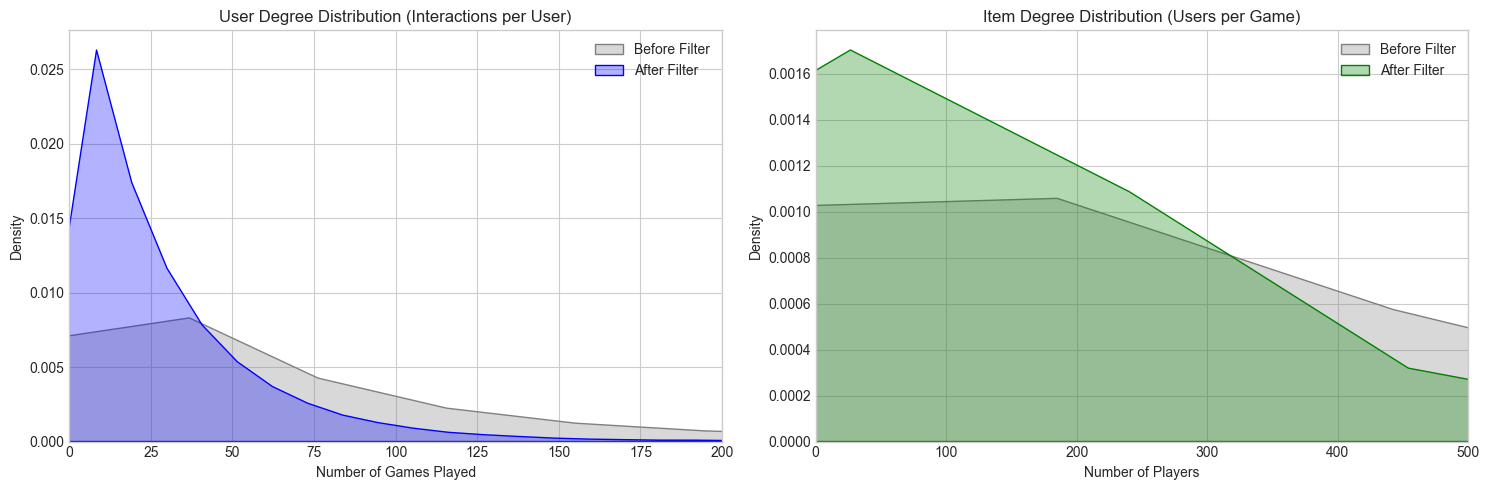

In [3]:
# ====== 3. 밀도 분석 및 필터링 (Density & Filtering) ======

FILTER_THRESHOLD = 120 # 분 (minutes)

# 1. 필터링 전 (Raw Metrics)
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_interactions = len(df)
density_raw = (n_interactions / (n_users * n_items)) * 100

print(f"[필터링 전]")
print(f"- 상호작용 수: {n_interactions:,}")
print(f"- 행렬 크기: {n_users:,} 유저 x {n_items:,} 아이템")
print(f"- 행렬 밀도: {density_raw:.4f}%")

# 2. 필터링 적용 (Apply Filter)
df_clean = df[df['playtime_forever'] > FILTER_THRESHOLD].copy()

# 3. 필터링 후 (Filtered Metrics)
n_users_c = df_clean['user_id'].nunique()
n_items_c = df_clean['item_id'].nunique()
n_interactions_c = len(df_clean)
density_clean = (n_interactions_c / (n_users_c * n_items_c)) * 100

print(f"\n[필터링 후 (> {FILTER_THRESHOLD}분)]")
print(f"- 상호작용 수: {n_interactions_c:,} ({n_interactions - n_interactions_c:,} 건의 노이즈 제거됨)")
print(f"- 행렬 크기: {n_users_c:,} 유저 x {n_items_c:,} 아이템")
print(f"- 행렬 밀도: {density_clean:.4f}%")

# 4. 변화율 (Change)
density_change = (density_clean - density_raw) / density_raw * 100
if density_change >= 0:
    print(f"\n>>> 밀도 증가: {density_change:.1f}%")
else:
    print(f"\n>>> 밀도 감소: {abs(density_change):.1f}% (필터링 후 더 희소해짐)")

# 5. 밀도(Degree) 분포 시각화 (User Interaction Comparison)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# User Degree (유저당 플레이 게임 수)
user_degrees_raw = df.groupby('user_id')['item_id'].count()
user_degrees_clean = df_clean.groupby('user_id')['item_id'].count()

sns.kdeplot(user_degrees_raw, ax=axes[0], label='Before Filter', color='gray', fill=True, alpha=0.3)
sns.kdeplot(user_degrees_clean, ax=axes[0], label='After Filter', color='blue', fill=True, alpha=0.3)
axes[0].set_title("User Degree Distribution (Interactions per User)")
axes[0].set_xlabel("Number of Games Played")
axes[0].set_xlim(0, 200) # 꼬리 부분 가독성을 위해 제한
axes[0].legend()

# Item Degree (게임당 유저 수)
item_degrees_raw = df.groupby('item_id')['user_id'].count()
item_degrees_clean = df_clean.groupby('item_id')['user_id'].count()

sns.kdeplot(item_degrees_raw, ax=axes[1], label='Before Filter', color='gray', fill=True, alpha=0.3)
sns.kdeplot(item_degrees_clean, ax=axes[1], label='After Filter', color='green', fill=True, alpha=0.3)
axes[1].set_title("Item Degree Distribution (Users per Game)")
axes[1].set_xlabel("Number of Players")
axes[1].set_xlim(0, 500)
axes[1].legend()

plt.tight_layout()
save_dir = 'assets/interaction_review'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, 'density_change_dist.png'))
print(f"\n밀도 변화 분포 플롯 저장 완료: {os.path.join(save_dir, 'density_change_dist.png')}")
plt.show()

필터링된 유저 플레이 통계 (user 단위) describe:
       games_played  total_playtime  mean_playtime  median_playtime
count  66790.000000    6.679000e+04   66790.000000     66790.000000
mean      29.354499    7.571229e+04    3466.479444      1425.090163
std       43.683993    9.106808e+04    5369.290367      4440.519481
min        1.000000    1.210000e+02     121.000000       121.000000
25%        7.000000    1.559925e+04    1268.109028       485.000000
50%       18.000000    4.895150e+04    2182.928968       707.000000
75%       39.000000    1.055882e+05    3839.477941      1127.500000
max     2118.000000    4.654466e+06  216412.000000    216412.000000
롱테일 플롯 저장 완료: assets/interaction_review\filtered_user_playtime_longtail.png


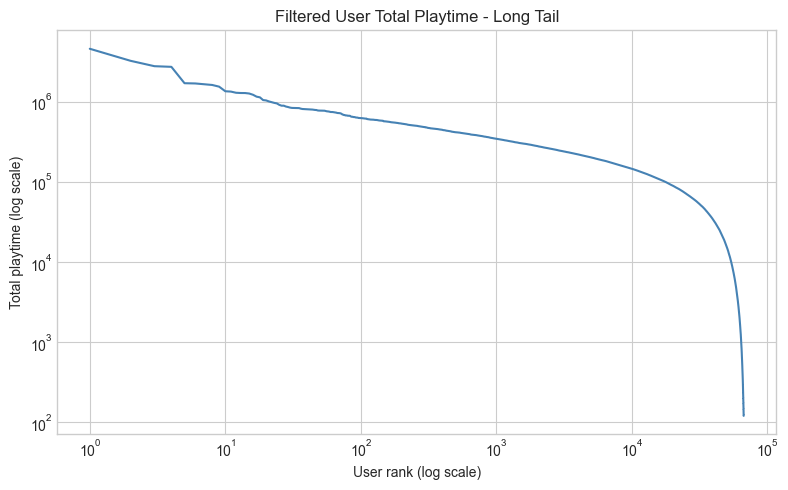

In [4]:
# ====== 4. 필터링 유저 플레이 통계 & 롱테일 ======

# 유저 단위 집계
user_play_stats = (
    df_clean.groupby('user_id')
    .agg(
        games_played=('item_id', 'count'),
        total_playtime=('playtime_forever', 'sum'),
        mean_playtime=('playtime_forever', 'mean'),
        median_playtime=('playtime_forever', 'median'),
    )
)

print("필터링된 유저 플레이 통계 (user 단위) describe:")
print(user_play_stats[['games_played', 'total_playtime', 'mean_playtime', 'median_playtime']].describe())

# Long-tail 확인: 유저별 총 플레이타임 분포 (log-log)
user_total_playtime = user_play_stats['total_playtime'].sort_values(ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, len(user_total_playtime) + 1), user_total_playtime.values, color='steelblue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Filtered User Total Playtime - Long Tail")
ax.set_xlabel("User rank (log scale)")
ax.set_ylabel("Total playtime (log scale)")

plt.tight_layout()
save_dir = 'assets/interaction_review'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'filtered_user_playtime_longtail.png')
plt.savefig(save_path)
print(f"롱테일 플롯 저장 완료: {save_path}")
plt.show()


In [5]:
# ====== 4-1. 이상치/결측치 점검 ======

# 결측치 및 비정상 값 확인
missing_playtime = df_clean['playtime_forever'].isna().sum()
non_positive_playtime = (df_clean['playtime_forever'] <= 0).sum()
print(f"playtime_forever 결측치: {missing_playtime}")
print(f"playtime_forever <= 0: {non_positive_playtime}")

# user_id / item_id 결측치 확인
missing_user = df_clean['user_id'].isna().sum()
missing_item = df_clean['item_id'].isna().sum()
print(f"user_id 결측치: {missing_user}")
print(f"item_id 결측치: {missing_item}")

# 결측치 행 비율/샘플 확인
missing_rows = df_clean[df_clean[['user_id', 'item_id', 'playtime_forever']].isnull().any(axis=1)]
print(f"결측치 포함 행 수: {len(missing_rows)}")
print(missing_rows.head())

# 원본 분포 퍼센타일 (분 단위)
percentiles = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]
print("\n[playtime_forever 분포 퍼센타일]")
print(df_clean['playtime_forever'].describe(percentiles=percentiles))

# 유저 단위 퍼센타일
print("\n[user 단위 퍼센타일]")
user_quantiles = user_play_stats[['games_played', 'total_playtime', 'mean_playtime', 'median_playtime']].quantile(percentiles)
print(user_quantiles.T)

# IQR 상한 기준 outlier 수
def iqr_upper(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q3 + 1.5 * iqr

for col in ['mean_playtime', 'median_playtime', 'total_playtime']:
    upper = iqr_upper(user_play_stats[col])
    count = (user_play_stats[col] > upper).sum()
    print(f"{col} IQR 상한: {upper:.1f}, 상한 초과 유저: {count:,}명")

# 상위 유저 샘플
print("\n[mean_playtime 상위 10 유저]")
print(user_play_stats.sort_values('mean_playtime', ascending=False).head(10))


playtime_forever 결측치: 0
playtime_forever <= 0: 0
user_id 결측치: 0
item_id 결측치: 0
결측치 포함 행 수: 0
Empty DataFrame
Columns: [user_id, item_id, playtime_forever]
Index: []

[playtime_forever 분포 퍼센타일]
count    1.960587e+06
mean     2.579240e+03
std      8.549350e+03
min      1.210000e+02
50%      6.040000e+02
90%      4.984000e+03
95%      1.009600e+04
99%      3.682214e+04
99.5%    5.498800e+04
99.9%    1.082550e+05
max      6.427730e+05
Name: playtime_forever, dtype: float64

[user 단위 퍼센타일]
                        0.500       0.900          0.950      0.990  \
games_played        18.000000      67.000      90.000000     156.00   
total_playtime   48951.500000  180503.900  238056.850000  392712.75   
mean_playtime     2182.928968    6759.384    9849.366346   23062.42   
median_playtime    707.000000    2081.050    3612.275000   15094.95   

                       0.995       0.999  
games_played        197.0550     440.844  
total_playtime   470016.1900  733936.926  
mean_playtime     31929.0

In [6]:
# ====== 5. Feature Engineering: 아이템별 백분위수 기반 점수 (Percentile Scoring) ======

def calculate_implicit_score(df):
    print("아이템별 Playtime 통계(Median, Std) 기반 Implicit Score 계산 중...")
    
    # 1. 로그 변환 (Log Transformation)
    # 플레이타임 분포의 왜도(Skewness)를 완화하기 위해 Log(x+1) 변환 사용
    df['log_playtime'] = np.log1p(df['playtime_forever'])
    
    # 2. 아이템별 통계 계산 (Median, Std)
    stats_df = df.groupby('item_id')['log_playtime'].agg(['median', 'std']).reset_index()
    stats_df.columns = ['item_id', 'item_median', 'item_std']
    
    # std가 0이거나 NaN인 경우 기본값 1.0 처리 (분모 0 방지)
    stats_df['item_std'] = stats_df['item_std'].fillna(1.0) 
    stats_df.loc[stats_df['item_std'] == 0, 'item_std'] = 1.0 
    
    # 3. 원본 데이터와 병합
    df_merged = df.merge(stats_df, on='item_id', how='left')
    
    # 4. Z-Score 계산: (LogPlaytime - Median) / Std
    df_merged['z_score'] = (df_merged['log_playtime'] - df_merged['item_median']) / df_merged['item_std']
    
    # 5. CDF를 이용한 확률(백분위) 변환 (0.0 ~ 1.0)
    # 정규분포 가정 하의 누적확률분포 값 (이 유저가 상위 n% 인지 나타냄)
    df_merged['implicit_score'] = stats.norm.cdf(df_merged['z_score'])
    
    # 결과 정리
    return df_merged[['user_id', 'item_id', 'playtime_forever', 'implicit_score']]

final_df = calculate_implicit_score(df_clean)

print("변환된 데이터 상위 5행:")
print(final_df.head())
print("\nImplicit Score 기술 통계:")
print(final_df['implicit_score'].describe())

아이템별 Playtime 통계(Median, Std) 기반 Implicit Score 계산 중...
변환된 데이터 상위 5행:
             user_id item_id  playtime_forever  implicit_score
0  76561197970982479     300              4733        0.940978
1  76561197970982479     240              1853        0.611931
2  76561197970982479    3830               333        0.357019
3  76561197970982479    3900               338        0.329721
4  76561197970982479    6400               286        0.196184

Implicit Score 기술 통계:
count    1.960587e+06
mean     5.090501e-01
std      2.880871e-01
min      6.681673e-05
25%      2.524692e-01
50%      5.000000e-01
75%      7.616701e-01
max      1.000000e+00
Name: implicit_score, dtype: float64


C:\Users\rlaqu\AppData\Local\Temp\ipykernel_36928\1542883066.py:17: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rlaqu\AppData\Local\Temp\ipykernel_36928\1542883066.py:17: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rlaqu\AppData\Local\Temp\ipykernel_36928\1542883066.py:22: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.savefig(save_path)
C:\Users\rlaqu\AppData\Local\Temp\ipykernel_36928\1542883066.py:22: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.savefig(save_path)


플롯 저장 완료: assets/interaction_review\playtime_implicit_score_dist.png


c:\Users\rlaqu\Documents\GitHub\AI_Study_Logs\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rlaqu\Documents\GitHub\AI_Study_Logs\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


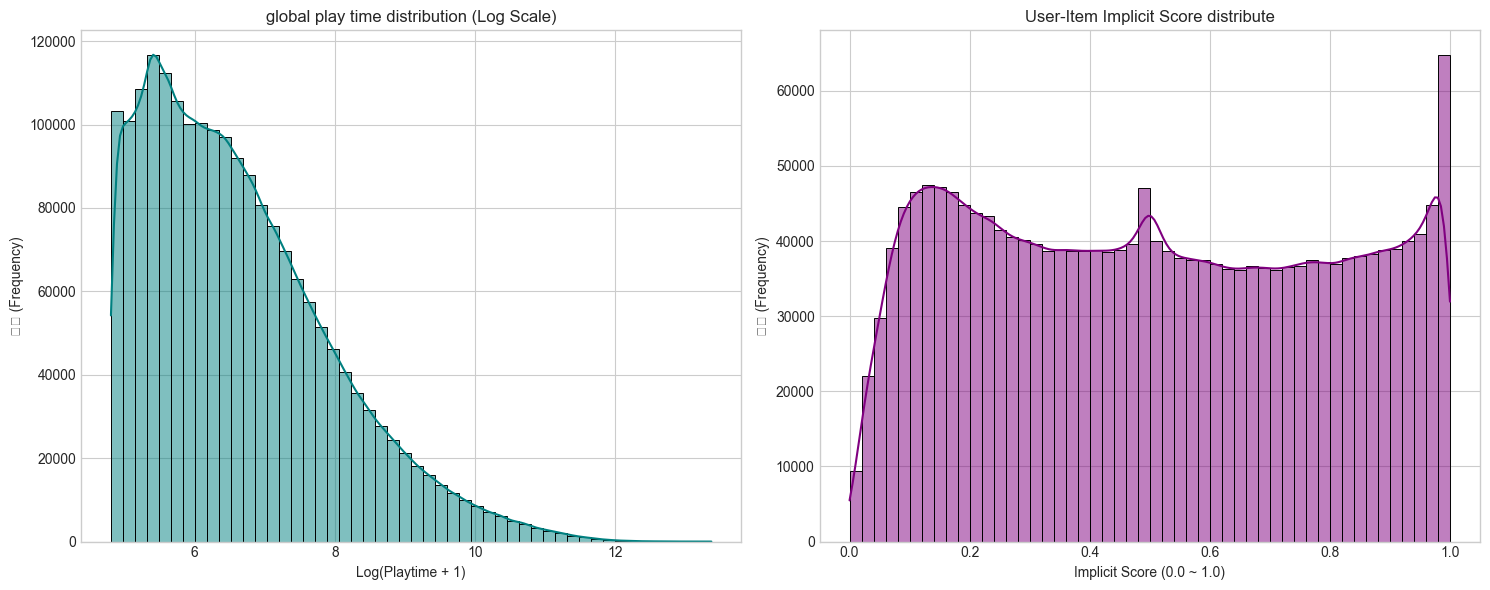

In [7]:
# ====== 6. 시각화 (Visualization) ======

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. 플레이타임 분포 (로그 스케일)
sns.histplot(np.log1p(df_clean['playtime_forever']), bins=50, ax=axes[0], color='teal', kde=True)
axes[0].set_title("global play time distribution (Log Scale)")
axes[0].set_xlabel("Log(Playtime + 1)")
axes[0].set_ylabel("빈도 (Frequency)")

# 2. Implicit Score 분포
sns.histplot(final_df['implicit_score'], bins=50, ax=axes[1], color='purple', kde=True)
axes[1].set_title("User-Item Implicit Score distribute")
axes[1].set_xlabel("Implicit Score (0.0 ~ 1.0)")
axes[1].set_ylabel("빈도 (Frequency)")

plt.tight_layout()
save_dir = 'assets/interaction_review'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'playtime_implicit_score_dist.png')
plt.savefig(save_path)
print(f"플롯 저장 완료: {save_path}")
plt.show()

## 💡 핵심 발견 (Key Findings)
- **필터링 전략:** 2시간 미만 플레이 제거는 유효함.
- **결과:** 행렬 밀도는 0.6620%에서 0.3521%로 감소해 더 희소해짐.
- **평점:** 자체 제작한 평점 스케일을 통해 '찍먹' 유저와 '하드코어' 팬을 구분 가능함.

## 📄 Interaction 분석 보고서

### 1) 데이터 개요
- 원본 상호작용 수: 5,153,209
- 행렬 크기: 70,912 유저 x 10,978 아이템
- 행렬 밀도: 0.6620% (매우 희소)

### 2) 필터링 결과 (> 120분)
- 상호작용 수: 1,960,587 (3,192,622 건의 노이즈 제거)
- 행렬 크기: 66,790 유저 x 8,336 아이템
- 행렬 밀도: 0.3521% → 약 46.8% 감소 (더 희소)
- 해석: 질적 노이즈는 감소했지만 희소성은 증가함

### 3) 유저 단위 통계 및 롱테일
- `games_played`, `total_playtime`, `mean_playtime`, `median_playtime` 기준으로 유저별 분포가 강한 롱테일 형태임
- 일부 상위 유저가 평균/중앙값을 끌어올리는 경향이 있어 이상치 영향 가능성이 큼

### 4) 이상치/결측치 점검
- `playtime_forever`, `user_id`, `item_id` 결측치 및 0 이하 값 여부 점검
- 퍼센타일/IQR 상한 기준으로 이상치 규모를 확인하고 필요 시 캡핑/제거 고려

### 5) 다음 단계 제안
1. 이상치 처리 방식 결정(상위 퍼센타일 캡, 로그 변환, 제거 등)
2. 처리 후 밀도/분포 재측정 및 롱테일 변화 확인
3. implicit score 계산 및 추천 모델 학습 성능 비교
